In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import datetime

## 1. to predict market size of shared bike in Washington D.C
## 2. Get data

In [2]:
df = pd.read_csv('../data/train.csv')

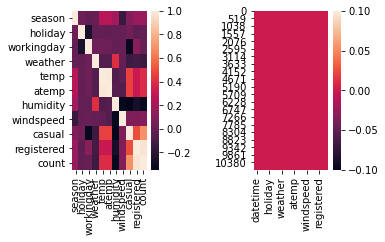

In [3]:
fig, (ax1, ax2)=plt.subplots(1,2) 
sns.heatmap(df.corr(), ax=ax1) 
sns.heatmap(df.isnull(), ax = ax2)
fig.tight_layout(pad=3)

# 3. split data

In [4]:
X = df.loc[:,df.columns!='count']
y = df['count']
X.shape, y.shape

((10886, 11), (10886,))

In [5]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=42)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((8164, 11), (2722, 11), (8164,), (2722,))

# 4. explore the data 

In [6]:
df_train = pd.concat((Xtrain,ytrain), axis=1)
#df_train['datetime'] = pd.to_datetime(df_train['datetime'])

In [7]:
def df_transform(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['month']=df.iloc[:,0].dt.month
    df['year'] = df.iloc[:,0].dt.year
    df['day'] = df.iloc[:,0].dt.day
    df['hour'] = df.iloc[:,0].dt.hour
    df['datetime'] = pd.to_datetime(df['datetime'])
    df=df.set_index(keys = 'datetime', drop = False, append = False, 
                   #verify_integrity=10, improve the performance
                  )
    df['datetime']= [time.mktime(df['datetime'][i].timetuple())/10**8 for i in range(df.shape[0])]
    return df
df_transform(df_train)
df_train=df_transform(df_train)

- caterical feature: season, holiday, workingday, casual, registered
- numerical and continous feature: number_ atemp, temp, humidity, windspeed

### 4.2 skip ploting data, try plot PCA

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
trans= StandardScaler()

In [10]:
trans.fit(df_train.loc[:,df_train.columns!='count'])
pca_fit = trans.transform(df_train.loc[:,df_train.columns!='count'])

In [11]:
features = pca_fit.T
cov_matrix = np.cov(features)
values, vectors = np.linalg.eig(cov_matrix)
vectors.shape, values.shape

((15, 15), (15,))

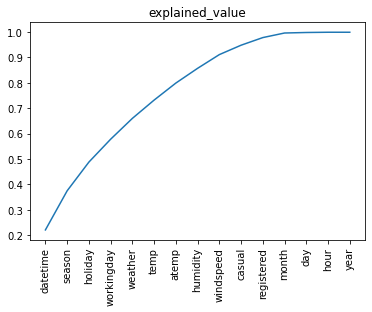

In [12]:
explained_value=[]
for i in range(len(values)):
    explained_value.append(round(values[i]/ np.sum(values),3))
explained_value = pd.DataFrame(explained_value, df_train.loc[:,df_train.columns!='count'].columns,columns=['explained_value']).sort_values('explained_value', ascending=False)
cumulative = np.cumsum(explained_value['explained_value'])
plt.plot(explained_value.index,cumulative)
plt.xticks(explained_value.index,rotation='vertical')
plt.title('explained_value')
plt.show()

In [13]:
projected_1 = pca_fit.dot(vectors.T[0])
projected_2 = pca_fit.dot(vectors.T[1])
projected_3 = pca_fit.dot(vectors.T[2])

In [14]:
res = pd.DataFrame(projected_1, columns=['PC1'])
res['PC2'] = projected_2
res['PC3'] = projected_3
res['Y'] = ytrain
res.head()

,PC1,PC2,PC3,Y
0,0.146151,-0.608179,-1.928657,NaN
1,-0.974251,1.569374,1.137007,40.0
2,1.998872,0.679543,-0.614112,32.0
3,-1.848381,-0.353907,0.878836,NaN
4,3.616371,-0.103126,-0.568792,1.0


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

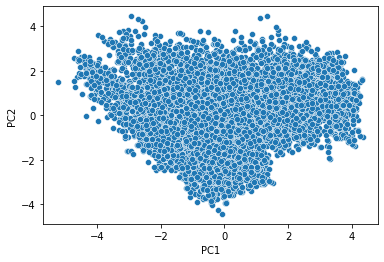

In [15]:
sns.scatterplot(data=res,x='PC1', y = 'PC2') # what can this tell me? have no idea yet!!!!!! how about down to 3 dimension? need to research more. 

# 5. Feature Eng

In [17]:
Xtrain=df_transform(Xtrain)

In [18]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,PolynomialFeatures, KBinsDiscretizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [19]:
Xtrain.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month',
       'year', 'day', 'hour'],
      dtype='object')

In [20]:
pipe_cal = make_pipeline((OneHotEncoder(sparse=False)))
pipe_matr = make_pipeline((KBinsDiscretizer(n_bins=6,encode='onehot')))
pipe_poly = make_pipeline((PolynomialFeatures(degree=2,interaction_only=False)),(StandardScaler(copy=False)))

In [21]:
feature_eng = make_column_transformer((pipe_cal,['season','holiday','workingday','weather','year']),
                                     (pipe_matr,['temp','atemp','humidity','windspeed','casual','registered','month','day','hour']),
                                     (pipe_poly,['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month',
       'year', 'day', 'hour']))

# 6. modelling

In [22]:
Xtrain_trans=feature_eng.fit_transform(Xtrain)

/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 6 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 7 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 8 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "


In [23]:
from sklearn.linear_model import LassoLars
lasso = LassoLars(alpha=0.6,jitter=0.001)
lasso.fit(Xtrain_trans,ytrain)

LassoLars(alpha=0.6, jitter=0.001)

In [24]:
lasso.score(Xtrain_trans,ytrain)

0.8797349748006486

In [25]:
lasso.coef_

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [26]:
lasso_pred=lasso.predict(Xtrain_trans)
lasso_pred

array([ 87.34131056, 221.05364205,  99.14647725, ..., 224.45215346,
        80.68136485, 322.423841  ])

# 7.1 cross validation

In [27]:
from sklearn.model_selection import cross_validate

In [28]:
lass_cross_val= cross_validate(lasso, Xtrain_trans,ytrain, cv=7)
lass_cross_val

{'fit_time': array([0.034024  , 0.02527714, 0.01790166, 0.01864314, 0.01690221,
        0.01547694, 0.01481819]),
 'score_time': array([0.0015769 , 0.000947  , 0.00071025, 0.00086498, 0.00072765,
        0.0005641 , 0.0008359 ]),
 'test_score': array([0.89148617, 0.89714472, 0.89616419, 0.89971234, 0.90032485,
        0.8927425 , 0.89016579])}

# - 7.2 Hyperparameter Optimisition

In [29]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

In [30]:
lasso_pipe = Pipeline([('preprocesser', feature_eng),
                       ('model1', LassoLars())
                       ])

In [31]:
hyparams = {'model1__alpha':[0.6,0.5,0.3],
           'model1__fit_intercept':['True','False'],
            'preprocesser__pipeline-2__kbinsdiscretizer__n_bins':[6,7,8]
           }

In [32]:
rg = RandomizedSearchCV(lasso_pipe, hyparams, cv = 5)

In [33]:
for i in rg.get_params().keys():
    print(i)

cv
error_score
estimator__memory
estimator__steps
estimator__verbose
estimator__preprocesser
estimator__model1
estimator__preprocesser__n_jobs
estimator__preprocesser__remainder
estimator__preprocesser__sparse_threshold
estimator__preprocesser__transformer_weights
estimator__preprocesser__transformers
estimator__preprocesser__verbose
estimator__preprocesser__pipeline-1
estimator__preprocesser__pipeline-2
estimator__preprocesser__pipeline-3
estimator__preprocesser__pipeline-1__memory
estimator__preprocesser__pipeline-1__steps
estimator__preprocesser__pipeline-1__verbose
estimator__preprocesser__pipeline-1__onehotencoder
estimator__preprocesser__pipeline-1__onehotencoder__categories
estimator__preprocesser__pipeline-1__onehotencoder__drop
estimator__preprocesser__pipeline-1__onehotencoder__dtype
estimator__preprocesser__pipeline-1__onehotencoder__handle_unknown
estimator__preprocesser__pipeline-1__onehotencoder__sparse
estimator__preprocesser__pipeline-2__memory
estimator__preprocesser__

In [34]:
rg.fit(Xtrain,ytrain)

/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 6 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 7 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 8 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.233e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocesser',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('onehotencoder',
                                                                                                OneHotEncoder(sparse=False))]),
                                                                               ['season',
                                                                                'holiday',
                                                                                'workingday',
                                                                                'weather',
                                                                                'year']),
                                                                              ('pipeline-2',
                              

In [35]:
rg.best_params_

{'preprocesser__pipeline-2__kbinsdiscretizer__n_bins': 6,
 'model1__fit_intercept': 'True',
 'model1__alpha': 0.5}

In [36]:
rg_cross_val = cross_validate(rg, Xtrain, ytrain, cv=4)

/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 6 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 7 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 8 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.303e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter 

In [37]:
rg_cross_val

{'fit_time': array([4.24814582, 4.60268426, 5.31746078, 5.86195302]),
 'score_time': array([0.01885319, 0.02165294, 0.02555394, 0.00446796]),
 'test_score': array([0.97655283, 0.97733628, 0.93890527,        nan])}

# 7.3 adjust params in model

# try kaggle

In [38]:
kaggle_test = pd.read_csv('../data/test.csv')

In [39]:
kaggle_test = df_transform(kaggle_test)
kaggle_test.head(2) # kaggle has no casual and registered, need to predict them first.

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,year,day,hour
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,12.954780,1,0,1,1,10.66,11.365,56,26.0027,1,2011,20,0
2011-01-20 01:00:00,12.954816,1,0,1,1,10.66,13.635,56,0.0000,1,2011,20,1


In [40]:
X_train_kaggle = Xtrain.loc[:,(Xtrain.columns!='casual')&(Xtrain.columns!='registered')]

In [41]:
X_train_kaggle.columns == kaggle_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [42]:
y_train_kaggle_casual = Xtrain['casual']
y_train_kaggle_registered = Xtrain['registered']
y_train_kaggle_casual.shape, y_train_kaggle_registered.shape

((8164,), (8164,))

In [43]:
feature_eng_kaggle = make_column_transformer((pipe_cal,['season','holiday','workingday','weather','year']),
                                     (pipe_matr,['temp','atemp','humidity','windspeed','month','day','hour']),
                                     (pipe_poly,['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed','year','hour','day','month'])
                                            )

In [44]:
X_train_kaggle_trans = feature_eng_kaggle.fit_transform(X_train_kaggle)

/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 4 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 5 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 6 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "


In [45]:
kaggle_test_trans = feature_eng_kaggle.fit_transform(kaggle_test)

In [46]:
# this is slow
from sklearn.ensemble import RandomForestRegressor
rf_casual = RandomForestRegressor(max_depth=10)
rf_casual.fit(X_train_kaggle,y_train_kaggle_casual)

RandomForestRegressor(max_depth=10)

In [49]:
rf_casual.feature_importances_, X_train_kaggle.columns

(array([0.        , 0.05138264, 0.00739324, 0.2051246 , 0.02019094,
        0.09952231, 0.29916891, 0.24999883, 0.06721854, 0.        ,
        0.        , 0.        , 0.        ]),
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed', 'month', 'year', 'day', 'hour'],
       dtype='object'))

In [51]:
rf_casual.score(X_train_kaggle, y_train_kaggle_casual)

0.8163588330921464

In [52]:
pred_casual=rf_casual.predict(kaggle_test) 

In [55]:
rf_registered=RandomForestRegressor()
rf_registered.fit(X_train_kaggle, y_train_kaggle_registered)

RandomForestRegressor()

In [56]:
rf_registered.feature_importances_

array([0.        , 0.07479078, 0.00576804, 0.03793468, 0.06247164,
       0.14369718, 0.195587  , 0.25667275, 0.22307794, 0.        ,
       0.        , 0.        , 0.        ])

In [57]:
pred_registered = rf_registered.predict(kaggle_test)

In [58]:
submission=pd.read_csv('../data/sampleSubmission.csv')

In [59]:
submission['count']=(pred_casual+pred_registered).astype(int)

In [60]:
submission.to_csv('submission.csv',index=False)